In [42]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

%run ./utils-graph.ipynb

global baseField
baseField = "like_label"

from datetime import datetime, timedelta
global start_time
start_time = datetime.now()
print(start_time)

2025-12-04 15:56:31.816282


In [43]:
time_caten_v = 'base_0'
time_model_v = 'base_0'
time_eval_v = 'base_0'

In [44]:
## Load Model
import joblib

model_y_test_path = './data_and_models/'+time_model_v+'/y_test.pkl'
model_y_test = pd.read_pickle(model_y_test_path)

model_path = './data_and_models/'+time_model_v+'/001_xgboost/1/model.pkl'
model = joblib.load(model_path)


In [45]:
## Load Data

exclude_fields = []

x_test_path = './data_and_models/'+time_eval_v+'/x_test.pkl'
y_test_path = './data_and_models/'+time_eval_v+'/y_test.pkl'

X_test = pd.read_pickle(x_test_path)
X_test_id = X_test[['mb_id']]
X_test.drop(exclude_fields, axis=1, inplace=True)

y_test = pd.read_pickle(y_test_path)[baseField]

<Axes: >

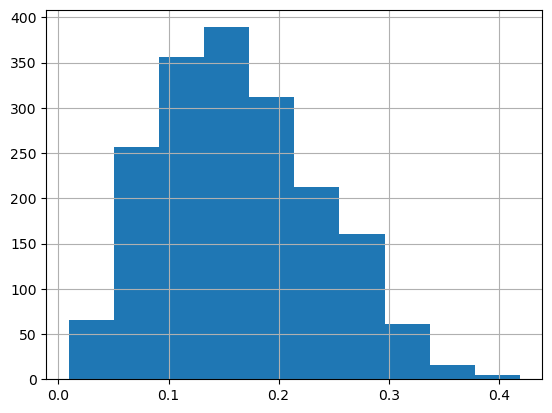

In [46]:
X_test['rms'].hist()

In [47]:
print(X_test.info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Index: 1834 entries, 2658 to 3773
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   genre              1834 non-null   category
 1   rms                1834 non-null   float64 
 2   zcr                1834 non-null   float64 
 3   spectral_centroid  1834 non-null   float64 
 4   spectral_rolloff   1834 non-null   float64 
 5   mfcc_1             1834 non-null   float64 
 6   mfcc_2             1834 non-null   float64 
 7   mfcc_3             1834 non-null   float64 
 8   mfcc_4             1834 non-null   float64 
 9   mfcc_5             1834 non-null   float64 
 10  mfcc_6             1834 non-null   float64 
 11  mfcc_7             1834 non-null   float64 
 12  mfcc_8             1834 non-null   float64 
 13  mfcc_9             1834 non-null   float64 
 14  mfcc_10            1834 non-null   float64 
 15  mfcc_11            1834 non-null   float64 
 16  mfcc_12 

In [48]:
xrow = X_test.iloc[0]
print(xrow.to_dict())

{'genre': 'folklore', 'rms': 0.1156529709696769, 'zcr': 0.0911014155007497, 'spectral_centroid': 1958.209778020927, 'spectral_rolloff': 4091.793960522577, 'mfcc_1': -150.03131103515625, 'mfcc_2': 94.4590301513672, 'mfcc_3': -13.842374801635742, 'mfcc_4': 41.97353363037109, 'mfcc_5': 0.136349931359291, 'mfcc_6': 16.60716438293457, 'mfcc_7': 0.3235604166984558, 'mfcc_8': 11.742025375366213, 'mfcc_9': -1.4390604496002195, 'mfcc_10': 13.40949535369873, 'mfcc_11': 6.652413845062256, 'mfcc_12': 9.13046646118164, 'mfcc_13': 5.313116073608398, 'chroma_C': 0.3633317947387695, 'chroma_C#': 0.3274720907211303, 'chroma_D': 0.3465883433818817, 'chroma_D#': 0.2533231675624847, 'chroma_E': 0.4067330956459045, 'chroma_F': 0.2322220206260681, 'chroma_F#': 0.3711797595024109, 'chroma_G': 0.5106967091560364, 'chroma_G#': 0.3505274951457977, 'chroma_A': 0.3254129886627197, 'chroma_A#': 0.3491814136505127, 'chroma_B': 0.5343990325927734, 'mb_id': 'b4e0f2bd-492d-466b-8ba5-dac43505a43a'}


In [49]:
enc_train_path = './data_and_models/'+time_caten_v+'/cat_ordinal_encoder.pkl'
enc = pickle.load(open(enc_train_path,'rb'))

In [50]:
## Encoding Function Start
def enc_transform(X: pd.DataFrame) -> pd.DataFrame:
  X = X.copy()
  cat_cols = enc.transform(X[cat_feats])
  cat_cols.fillna(-1, inplace=True)
  for i, name in enumerate(cat_feats):
      cat_cols[name] = pd.Categorical.from_codes(
          codes=cat_cols[name].astype(np.int32), 
          categories=enc.categories_[i]
      )
  X[cat_feats] = cat_cols
  return X
## Encoding Function End

### Applying Training Model Categories Encoding
cat_train_path = './data_and_models/'+time_caten_v+'/training_categories_array.pkl'
cat_feats = pickle.load(open(cat_train_path,'rb'))

enc_train_path = './data_and_models/'+time_caten_v+'/cat_ordinal_encoder.pkl'
enc = pickle.load(open(enc_train_path,'rb'))

X_test = enc_transform(X_test)

for name in cat_feats:
    X_test[name] = X_test[name].astype("category")
    if "NO_CAT_PLACEHOLDER" not in X_test[name].cat.categories:
        X_test[name] = X_test[name].cat.add_categories("NO_CAT_PLACEHOLDER").fillna("NO_CAT_PLACEHOLDER")

In [51]:
fixed_cat_fields = ['genre']

for cf in fixed_cat_fields:
    X_test[cf] = X_test[cf].astype('category')


# fixed_bool_fields = []
#
# for bf in fixed_bool_fields:
#     X_test[bf] = X_test[bf].astype('bool')
#
#
# fixed_float_fields = []
# for ff in fixed_float_fields:
#     X_test[ff] = pd.to_numeric(X_test[ff], errors='coerce').astype('float64')
#
#
# fixed_int_fields = []
#
# for i_f in fixed_int_fields:
#     X_test[i_f] = pd.to_numeric(X_test[i_f], errors='coerce')



In [52]:
features_list = sorted(X_test.columns.tolist())
exclude_list = ['mb_id']
features_list = [x for x in features_list if x not in exclude_list]

print(features_list)
print(len(features_list))

['chroma_A', 'chroma_A#', 'chroma_B', 'chroma_C', 'chroma_C#', 'chroma_D', 'chroma_D#', 'chroma_E', 'chroma_F', 'chroma_F#', 'chroma_G', 'chroma_G#', 'genre', 'mfcc_1', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'rms', 'spectral_centroid', 'spectral_rolloff', 'zcr']
30


In [53]:
X_test = X_test[features_list]

In [54]:
X_test.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1834 entries, 2658 to 3773
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   chroma_A           1834 non-null   float64 
 1   chroma_A#          1834 non-null   float64 
 2   chroma_B           1834 non-null   float64 
 3   chroma_C           1834 non-null   float64 
 4   chroma_C#          1834 non-null   float64 
 5   chroma_D           1834 non-null   float64 
 6   chroma_D#          1834 non-null   float64 
 7   chroma_E           1834 non-null   float64 
 8   chroma_F           1834 non-null   float64 
 9   chroma_F#          1834 non-null   float64 
 10  chroma_G           1834 non-null   float64 
 11  chroma_G#          1834 non-null   float64 
 12  genre              1834 non-null   category
 13  mfcc_1             1834 non-null   float64 
 14  mfcc_10            1834 non-null   float64 
 15  mfcc_11            1834 non-null   float64 
 16  mfcc_12 

In [55]:
y_predicted_proba = model.predict_proba(X_test)

In [56]:
# Export
def export_prediction(x_id, y_test, y_predicted_proba):

    x_id.reset_index(drop=True, inplace=True)

    df_y = pd.DataFrame(y_test)
    df_y.reset_index(drop=True, inplace=True)

    df_p = pd.DataFrame(y_predicted_proba)

    df_a = pd.concat([x_id, pd.concat([df_y, df_p], axis=1)], axis=1) [['mb_id']]

    # print(df_a.info())
    # print(df_a[df_a['isFraud']==1].head(10))
    df_a.to_csv('./data_and_models/'+time_eval_v+'/predictions.csv', index=False)


export_prediction(X_test_id, y_test, y_predicted_proba)

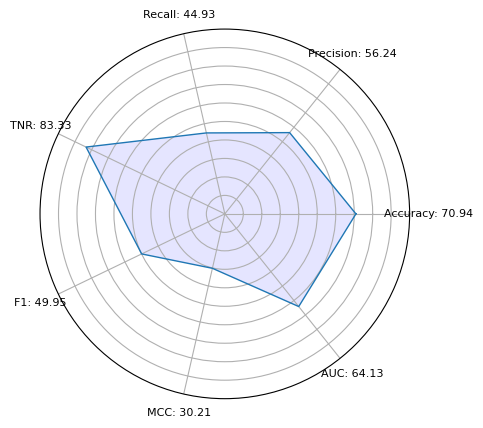

========= Prediction on Test Set =========
[[1035  207]
 [ 326  266]]
-----------
0.7093784078516903  <-- Accuracy (all correct / all)
0.5623678646934461  <-- Precision: (true positives / predicted positives)
0.44932432432432434  <-- Recall/TPR (true positives / all actual positives):
0.8333333333333334  <-- TNR (true negatives / all actual negatives):
0.499530516431925  <-- F1
0.3020805574231892  <-- MCC [-1..0..1]
0.6413288288288289  <-- AUC


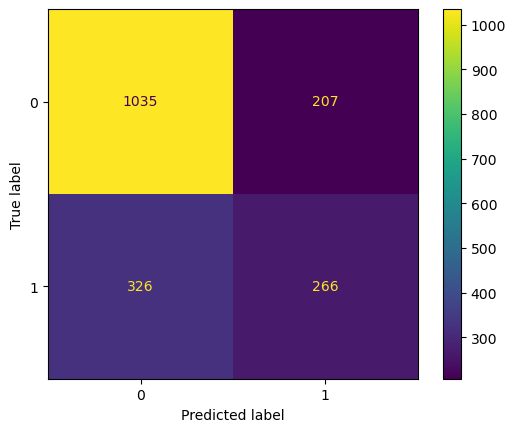

In [57]:
evaluate_metrics(y_test, y_predicted_proba, 0.5)

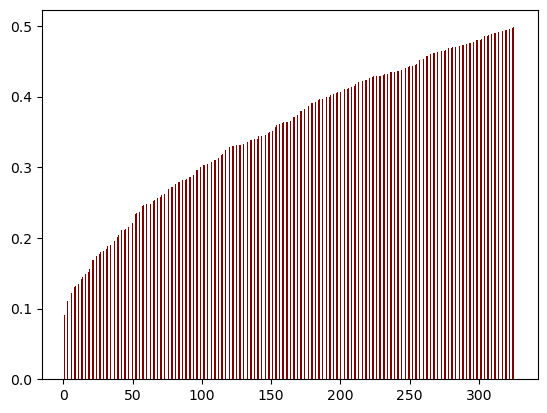

Count:  326


In [58]:
false_negative_list(y_test, y_predicted_proba, 0.5)

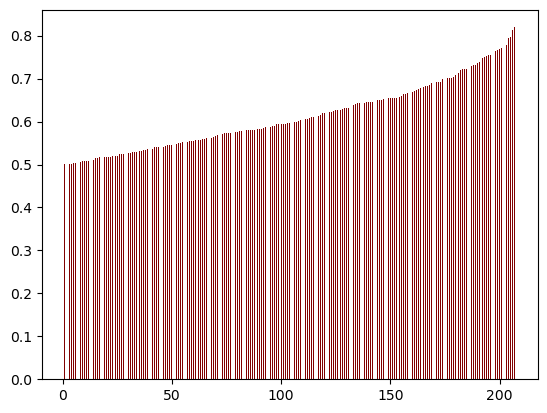

Count:  207


In [59]:
false_positive_list(y_test, y_predicted_proba, 0.5)

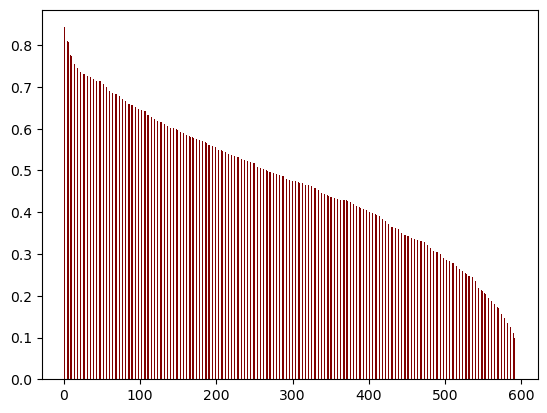

Count:  592
|      |   y |   predicted |
|-----:|----:|------------:|
| 1986 |   0 |    0.595358 |
| 4925 |   0 |    0.594387 |
| 1919 |   0 |    0.594385 |
|  819 |   1 |    0.594022 |
| 2754 |   0 |    0.593826 |
| 3591 |   1 |    0.593435 |
| 3384 |   0 |    0.593368 |
| 5256 |   1 |    0.591425 |
| 1793 |   1 |    0.590433 |
| 4711 |   1 |    0.590363 |


In [60]:
real_positive_list(y_test, y_predicted_proba, print_values_list=True, range_start=255, range_end=265)

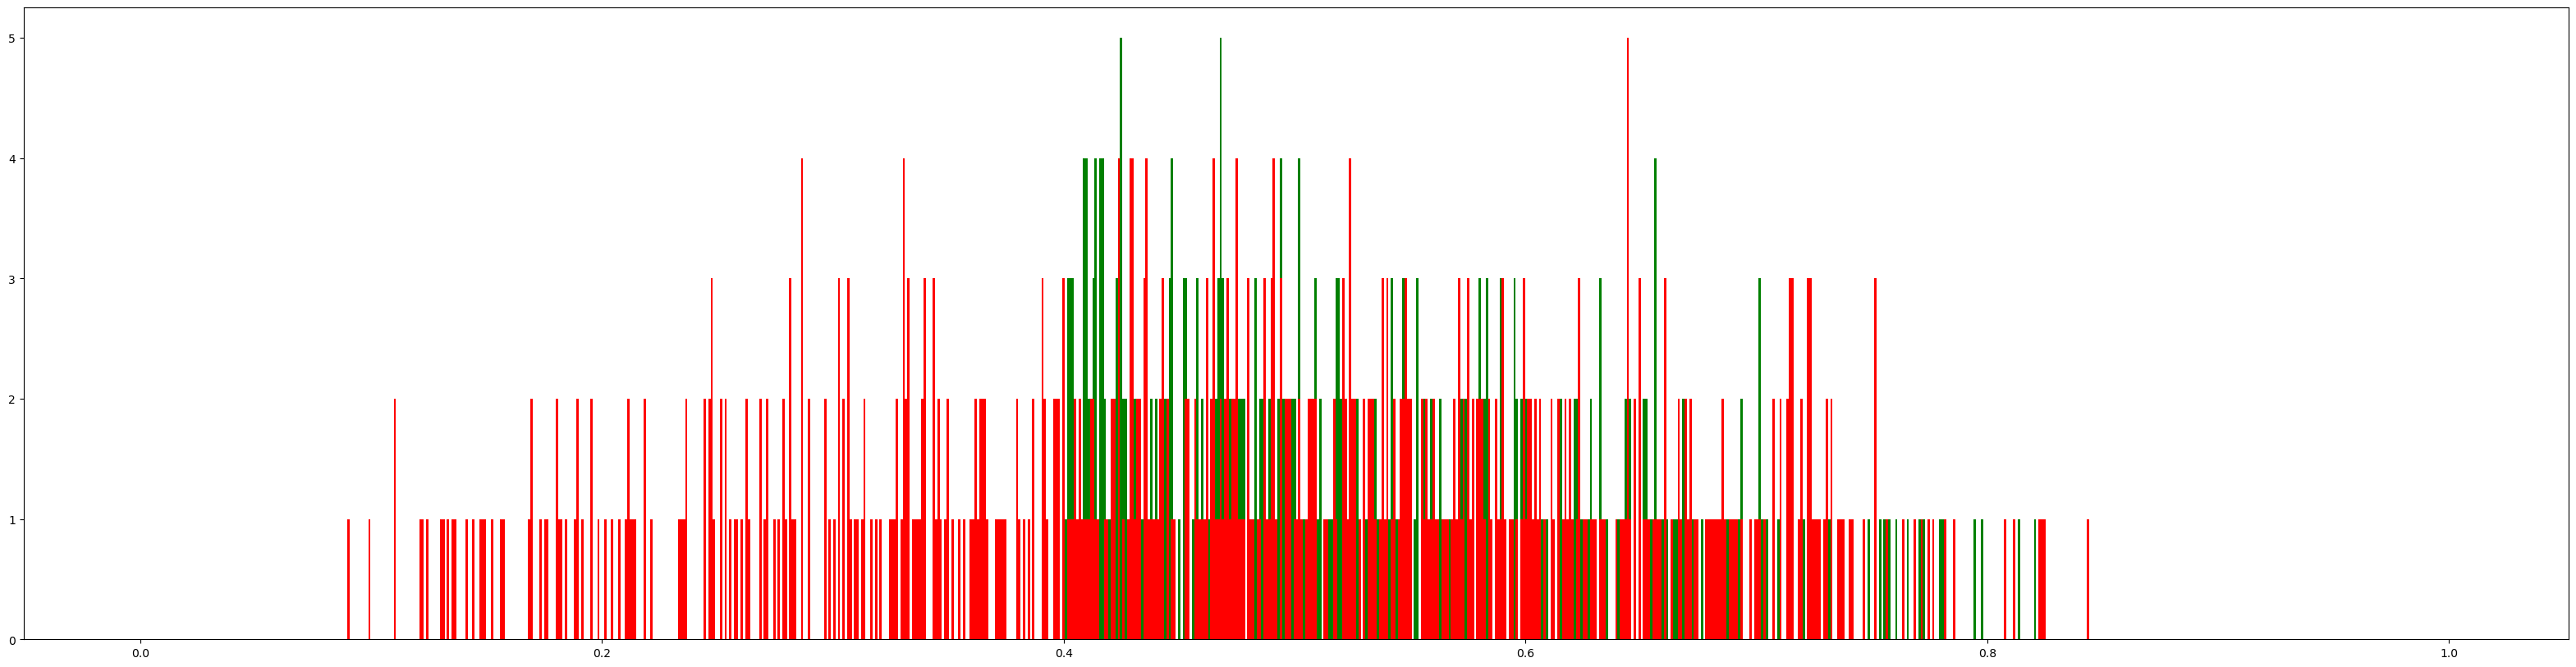

RED: Fraud Label Positive; Showing:  592
GREEN: Fraud Label Negative; Showing:  372  out of  1242
For visual purposes  870  real negative records with prediction <  0.4  are excluded


In [61]:
full_histogram(y_test, y_predicted_proba, buckets_count=1000, graph_negative_threshold=0.4)

|    | feature           |         mean |        std |
|---:|:------------------|-------------:|-----------:|
| 12 | genre             |  0.0800676   | 0.0123484  |
| 26 | rms               |  0.0425676   | 0.0139458  |
| 13 | mfcc_1            |  0.035473    | 0.00151086 |
| 25 | mfcc_9            |  0.0290541   | 0.00626596 |
| 16 | mfcc_12           |  0.0185811   | 0.0107367  |
|  3 | chroma_C          |  0.0182432   | 0.00458266 |
| 11 | chroma_G#         |  0.0168919   | 0.00151086 |
| 28 | spectral_rolloff  |  0.0148649   | 0.00445639 |
|  0 | chroma_A          |  0.0131757   | 0.00419246 |
|  5 | chroma_D          |  0.0108108   | 0.00274461 |
|  6 | chroma_D#         |  0.010473    | 0.00505629 |
|  1 | chroma_A#         |  0.00912162  | 0.0029452  |
| 14 | mfcc_10           |  0.00777027  | 0.00393983 |
|  7 | chroma_E          |  0.00709459  | 0.00743243 |
| 19 | mfcc_3            |  0.00608108  | 0.00507882 |
| 15 | mfcc_11           |  0.00574324  | 0.00331012 |
|  8 | chr

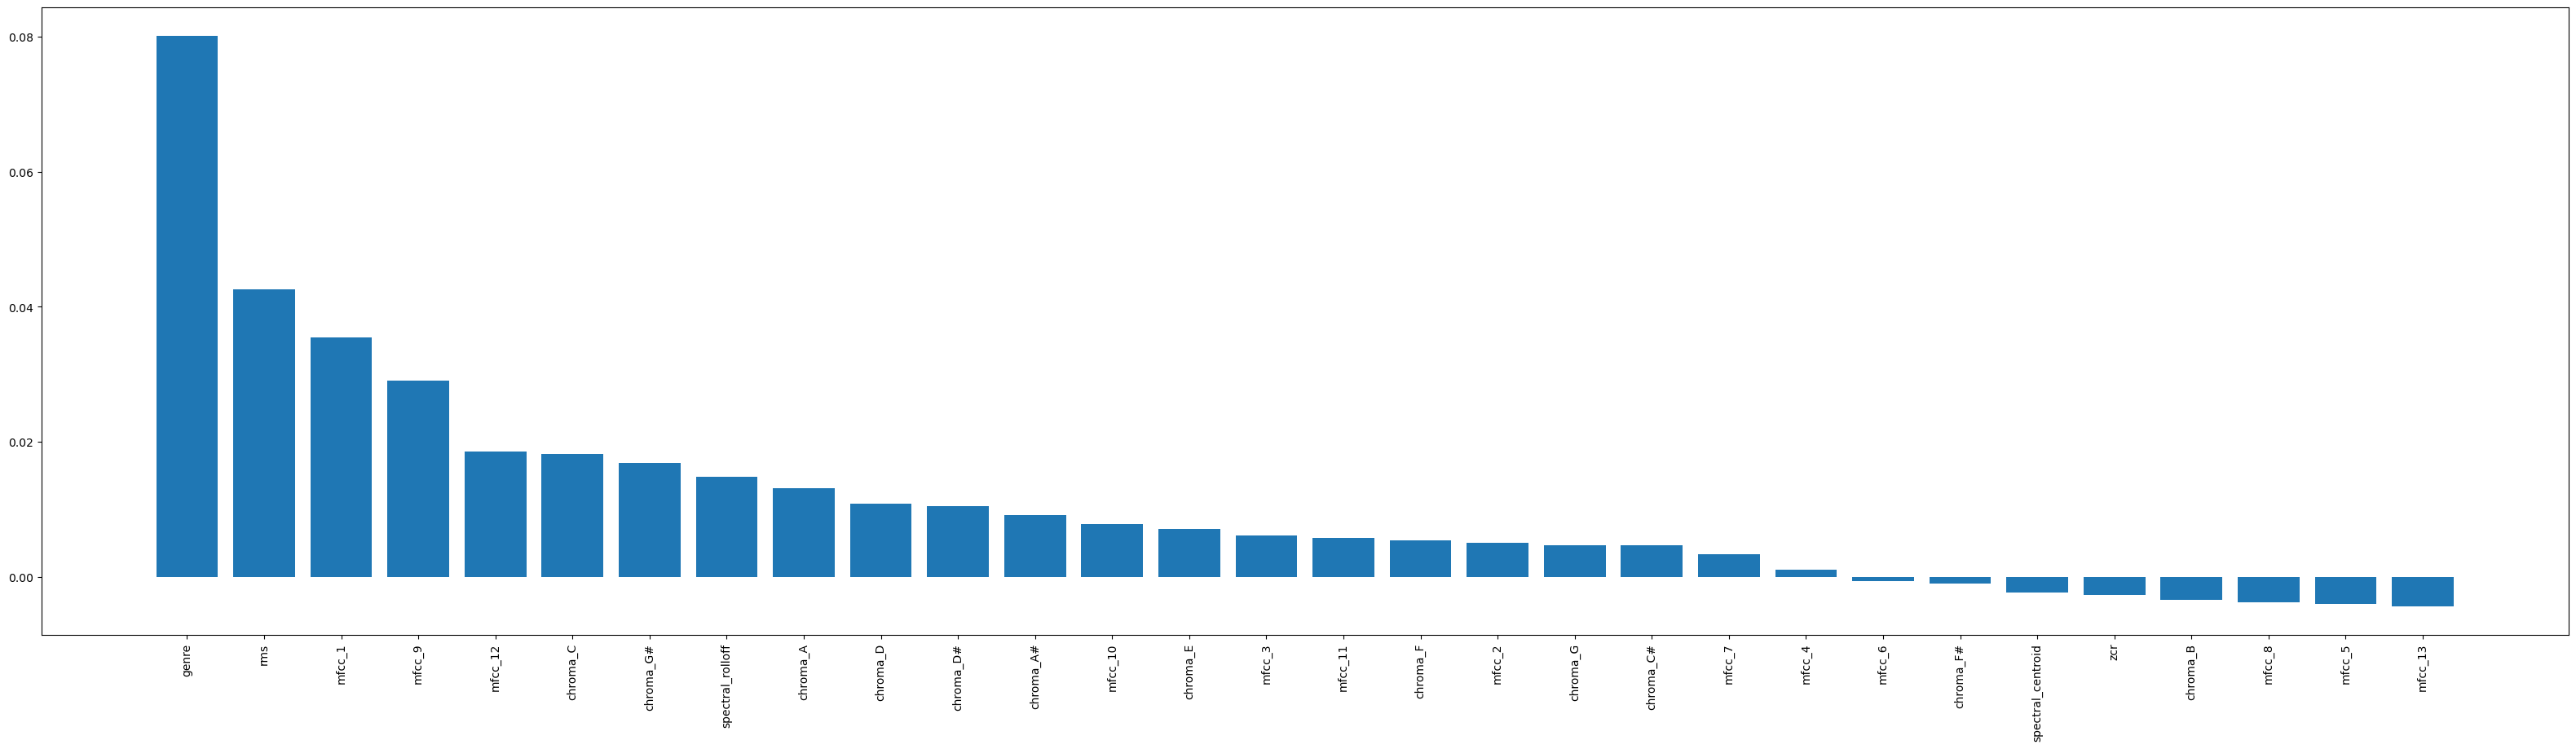

In [62]:
%%time

if True:
    from sklearn.inspection import permutation_importance
    result = permutation_importance(
        model, 
        X_test, 
        y_test, 
        scoring='recall',
        n_repeats=5
        )

    perm_importance = pd.DataFrame(columns=["feature", "mean", "std"], data= np.transpose([X_test.columns, result.importances_mean, result.importances_std]))
    perm_importance = perm_importance.sort_values(by=['mean'], ascending=False)

    print(perm_importance.to_markdown())

    plt.figure(figsize=(40, 10))
    plt.xticks(rotation=90)
    plt.bar(perm_importance['feature'], perm_importance['mean'])

In [63]:
print(datetime.now())
print(datetime.now()-start_time)

2025-12-04 15:56:39.916025
0:00:08.099853
